# Convolutional Neural Network
## Classification using the MNIST Dataset

This example will use the **MNIST** handwritten digits dataset from **Keras** to explore *deep learning* with a **Convolutional Neural Network**, also known as a *convnet*. Convnets are common in computer-vision applications, such as recognizong objects in images and video, and in non-vision applications, such as *natural-language processing*. **MNIST** has 70,000 labeled digit image samples: 60,000 for *training* and 10,000 for *testing*. Each sample is a gray-scale 28 x 28 pixel image: 784 total features represented as a *NumPy* array. **MNIST's** labels are *integer values* in the range of 0 through 9, indicating the digit each image represents. This *convnet* will perform **probabilistic classification**. The model will output an *array* of 10 probabilities, indicating the likelihood that the digit belongs to a particular one of the classes 0 through 9. The class with the *highest* probability is the predicted value.

__[More info on CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network)__

__[More info on Probalistic Classification](https://en.wikipedia.org/wiki/Probabilistic_classification)__

A **Keras** neural network will consist of the following:

* **Network** (*model*) - a sequence of *layers* containing the neurons used to learn from the samples. Each layer's neurons receive inputs, process them using an *activation function* and produce outputs. The data is fed into the network via an *input layer* that specifies the dimensions of the sample data. This is followed by *hidden layers* of neurons that implement the learning and an *output layer* that produces predictions. The more layers that are *stacked*, the deeper the network is. 

* **Loss Function** - produces a measure of how well the network predicts the *target* values. Lower loss values indicate better predictions

* **Optimizer** - attempts to minimize the values produced by the loss function to tune the network to make better predictions

We begin by importing `tensorflow.keras.datasets.mnist` model. The `mnist.load_data` function will download the MNIST data into the system, returning a tuple of tuples containg *training* and *testing* data, respectively. 

In [1]:
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Explore Data

It is good practice to become familiar with the data that will be used. This can be done by checking dimensions of the datasets and using `Matplotlib` and `Seaborn` to visualize the digit images. 

In [3]:
# check dimensions
X_train.shape

(60000, 28, 28)

In [4]:
# check dimensions
y_train.shape

(60000,)

In [5]:
# check dimensions
X_test.shape

(10000, 28, 28)

In [6]:
# check dimensions
y_test.shape

(10000,)

### Visualize data

Randomly select a set of 24 training set images by using *NumPy's* `choice` function. `%matplotlib inline ` is used to indicate graphics should be displayed in the notebook.

In [7]:
%matplotlib inline 

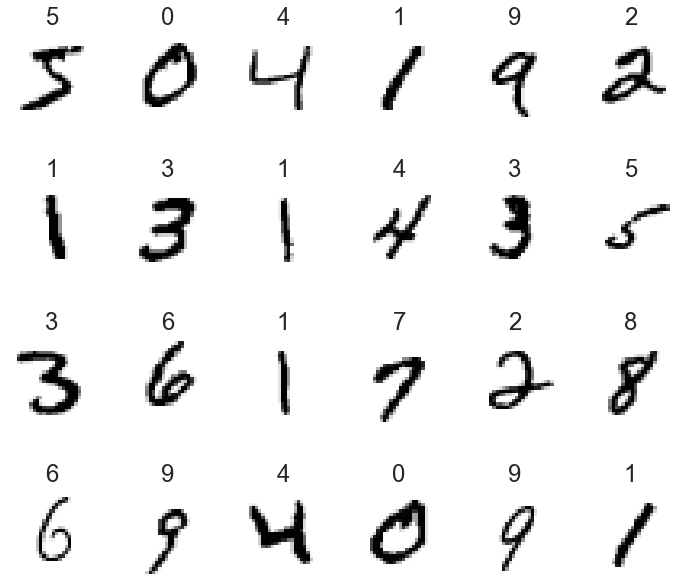

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(font_scale=2)

index = np.random.choice(np.arange(len(X_train)), 24, replace=False)
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(10, 9))

for item in zip(axes.ravel(), X_train, y_train):
    axes, image, target = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_axis_off() # remove x,y-axis tick marks
    axes.set_title(target)
plt.tight_layout()

### Prepare Data

**Reshape** 

*Keras convnets* requires the image data to be reshaped to ensure each sample has the same shape *(width, height, channels)*. Each sample's shape will be *(28,28,1)*.

In [9]:
# reshape 
X_train = X_train.reshape((60000, 28, 28, 1)) 

In [10]:
# confirm shape
X_train.shape

(60000, 28, 28, 1)

**Normalize**

Each pixel in the **MNIST** dataset is an integer in the range 0 - 255. The following statements convert the values to 32-bit (4-byte) flotaing-point numbers using the *NumPy* array method `astype`, then dividing every element in the resulting array by 255, producing *normalized* values in the range 0.0 - 1.0

In [11]:
X_train = X_train.astype('float32') / 255

In [12]:
X_test = X_test.reshape((10000, 28, 28, 1))

In [13]:
# confirm shape
X_test.shape

(10000, 28, 28, 1)

In [14]:
X_test = X_test.astype('float32') / 255

**Convert Labels**

As mentioned before, the data must be reshaped to ensure shapes match. However, the label for each digit is one integer value. The labels must be transformed into **categorical data** - arrays of categories that match the format of the predictions. This will be done by a process known as **one-hot encoding** - converts data into arrays of 1.0s and 0.0s in which only one element is 1.0 and the rest are 0.0. 

For example:
* 7 = [ 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0 ]

`tensorflow.keras.utils` provides the function `to_categorical` to perform **one-hot encoding**. This function counts the unique categories then, for each item being encoded, creates an array of that length with a 1.0 in the correct position

__[More info on One-hot Encoding](https://en.wikipedia.org/wiki/One-hot)__

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
# perform encoding
y_train = to_categorical(y_train)

In [17]:
# confirm shape
y_train.shape

(60000, 10)

In [18]:
# confirm encoding
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [19]:
# perform encoding
y_test = to_categorical(y_test)

In [20]:
# confirm encoding
y_test.shape

(10000, 10)

### Create Neural Network

The data has been prepared, now the **CNN** can be configured. The `Sequential` model will result in a network executing its layes *sequentially* - the output of one layer becomes the input to the next. This is also known as a *feed-forward network*.

In [21]:
from tensorflow.keras.models import Sequential

In [22]:
# configure CNN
cnn = Sequential()

**Add Layers**

A typical **CNN** will consist of several layers:

* **Input Layer** - receieves training samples

* **Hidden Layers** - learn from the samples 

* **Output Layer** - produces prediction probabilities

The following image illustrates convolution

![](convolution-with-multiple-filters2.png)

**Convolution**

The network will begin with a **convolution layer** - uses the relationships between pixels that are close to one another to learn useful features (or patterns) in small areas (*kernels or patches*) of each sample. These features become inputs to subsequent layers. The number of filters in the *convolutional layer* is commonly 32 or 64 when processing small images like those in **MNIST**. Each filter produces different results. The number of filters depends on the image dimensions - higher resolution images have more features, so they require more filters. The set of filters produced by a *convolution* layer is called a *feature map*.

Layers will be added using the `tensorflow.keras.layers ` module. Each module is explained:

* A *convolution layer* will be added by using the argument `Conv2D`
    * `filters` - the number of filters in the resulting feature map
       
    * `kernel_size` - The size of the kernel used in each filter
    
    * `acitvation` - The 'relu' (*Rectified Linear Unit*) is used to produce the layer's output. 'relu' is the most widely used activation function in today's deep learning networks especially for convolution layers. It is good for performance because it is easy to calulate.
    
    * `input_shape` - used in initital layer to specify the shape of each sample: (28, 28, 1) = 784 features. The specified 64 filters and 3 x 3 kernel size will produce an output for each image: (26, 26, 64) = 43, 264 features in the feature map
        
**Pooling** 

Overfitting can occur if a model becomes too complex compared to what it is modeling. This tends to occur in *deep learning* as the dimensionality of the layers becomes too large. This causes the network to learn *specific* features of the training-set digit images, instead of learning the *general* features of digit images and is computationally expensive. A *pooling layer* will be added after the convolution layer to reduce the dimensionality of the convolution layer's output. *Pooling layers* compresses the results by dicarding features. The most common pooling technique is *max pooling* - examines a 2 x 2 square of features and keeps only the maximum feature. For example: a *26 x 26 x 64* output will be reduced to *13 x 13 x 64*.

* A *pooling layer* will be added by using the argument `MaxPooling2D`
    * pool_size - the desired shape of reduction

__[More info on Convolution](https://en.wikipedia.org/wiki/Convolution)__

__[More info on Kernel Size](https://www.quora.com/How-can-I-decide-the-kernal-size-output-maps-and-layers-of-CNN)__

__[More info on Overfitting](https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a)__



In [23]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [24]:
# add first conv layer
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
               input_shape=(28, 28, 1)))
# add pooling layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))

In [25]:
# add hidden layer
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# add pooling layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))

In [26]:
# add hidden layer
cnn.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
# add pooling layer
cnn.add(MaxPooling2D(pool_size=(2, 2)))

**Flatten**

There will be a total of six layers that have been added to learn the digit features. The final output of the model will be a *one-dimensional* array of 10 probabilities that clissify the digits. The digits need to be *flattened* to prepare for output

* A *flatten layer* will be added using the argument `Flatten`
    * Flatten - reshapes its input to one dimension



In [27]:
cnn.add(Flatten())

**Reduction**

Now the model needs to learn the relationships among the features that have been learned so the model can classify which digit each image represents. A fully connected *dense layer* will allow the model to perform classification. The following *dense layer* will create 128 neurons (*units*) that learn from the outputs of the previous layer. Many convnets contain *dense layers*. The final layer of this model will be a *dense layer* that classifies the inputs into neurons representing the classes 0 - 9. The neuron that produces the highest probability represents the prediction for a given digit image. 

* Two *dense layers* will be added suing the argument `Dense`
    * `units` - desired amount of neurons to create
    * `acivation` - 'relu' was discussed during convolution, 'softmax' converts the values of the remaining neurons into classification probabilitiesrepresenting the prediciton for a given digit image



__[More info on Dense Layer](https://github.com/keras-team/keras-applications/tree/master/keras_applications)__

In [28]:
cnn.add(Dense(units=128, activation='relu'))

In [29]:
cnn.add(Dense(units=10, activation='softmax'))

**Summary**

The `summary` method will display the model's layers. This allows inspection of different details such as the output shapesof the various layers and amount of parameters (*weights*) that the network learns during training. This particular network is small, yet it will need to learn nearly 500,000 parameters. The `Output Shape` contains *none* this simply means the model does not know in advance how many training samples will be provided. This is only known when the model starts training. There are no *non-trainable* parameters since **Keras** trains *all* parameters, however, it is possible to prevent training for specific layers when tuning the network or using *transfer learning*

__[More infor on Summary](https://hackernoon.com/everything-you-need-to-know-about-neural-networks-8988c3ee4491)__

__[More info on Freezing Layers](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers)__

In [30]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

**Compile**

The model needs to be configured to be completed once all layers have been added. 

* This configuration will done by using `complile`
    * `optimizer` - the *optimizer* the model uses to adjust the weights throughout the network as it learns.
        * *'adam'* performs well for a variety of models
    * `loss` - *loss function* to be used by the optimizer, which attempts to minimize the values returned by the funciton.
        * *categorical_crossentropy* is used multi-classification networks. 
    * `metrics` - a list of the *metrics* that the network will produce to help with evalutation.
        * *'accuracy'* is commonly used in classification models

__[More info on Optimizers](https://keras.io/optimizers/)__

__[More info on Adam](https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2)__

__[More info on Loss Functions](https://keras.io/losses/)__

__[More info on Metrics](https://keras.io/metrics/)__

In [31]:
# compile model
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

**Training**

* The model will be trained using `fit` which will output information as the training proceeds
    * The first two arguments are the training data and the catagorical target labels
    * `epochs` - specifies the number of times the model should process the entire set of training data iteratively
    * `batch_size` - specifies the number of samples to process at a time during each epoch. Most models specifiy a power of 2 from 32 to 512. Large batch sizes can decrease accuracy
    * `validation_split` - uses some samples to *validate* the model after each epoch. The model uses this to make predictions and display the *validation loss and accuracy*. Here we indicate the model should reserve the last 10% (*0.1*) of the training samples (6,000)  for validation. 
    
 *TensorBoard* is a TensorFlow tool for visualizing data from deep-learning models
    
__[More info on Validation](https://keras.io/getting_started/faq/#how-is-the-validation-split-computed)__

__[More info on TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard)__

In [32]:
# train model
cnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 64s 1ms/sample - loss: 0.2104 - accuracy: 0.9338 - val_loss: 0.0691 - val_accuracy: 0.9805
Epoch 2/5
54000/54000 [==============================] - 67s 1ms/sample - loss: 0.0657 - accuracy: 0.9797 - val_loss: 0.0510 - val_accuracy: 0.9852
Epoch 3/5
54000/54000 [==============================] - 67s 1ms/sample - loss: 0.0476 - accuracy: 0.9852 - val_loss: 0.0607 - val_accuracy: 0.9805
Epoch 4/5
54000/54000 [==============================] - 64s 1ms/sample - loss: 0.0335 - accuracy: 0.9896 - val_loss: 0.0525 - val_accuracy: 0.9850
Epoch 5/5
54000/54000 [==============================] - 64s 1ms/sample - loss: 0.0272 - accuracy: 0.9909 - val_loss: 0.0455 - val_accuracy: 0.9873


### Evaluate

The function `evaluate` will be used to evaluate the models performance. The amount of time to process the test samples, the loss, and the accuracy of the model are displayed. The accuracy of this model is 98% when predicting the labels of unseen data without any tuning. 

In [33]:
loss, accuracy = cnn.evaluate(X_test, y_test)

10000/10000 [==============================] - 3s 261us/sample - loss: 0.0540 - accuracy: 0.9833


In [34]:
loss

0.05396386566829169

In [35]:
accuracy

0.9833

### Make Predictions

The model's `predict` will predict the classes of the digit images in its argument array *X_test*. The first element to test is a **7** which is represented by *one-hot encoding*. The following *for loop* will output the probabilities of each digit that the model believes is the test digit image. In this case, the model is just about 100% sure the first digit of test digit images is **7**. These probalilities will also be used to evaluate prediction errors.

In [36]:
# make predictions
predictions = cnn.predict(X_test)

In [37]:
# check first target
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [38]:
# display prediction probabilities
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

0: 0.0000319868%
1: 0.0087534951%
2: 0.0114937815%
3: 0.0012527918%
4: 0.0000218656%
5: 0.0007100382%
6: 0.0000001280%
7: 99.9757826328%
8: 0.0000194293%
9: 0.0019350842%


### Visualize Error

There are a few ways to view some of the incorrectly predicted digits. The incorrect predictions need to be indentified before they can be viewed. The probabilites such as the one displayed above can be used to determine if a prediction is incorrect. If the value of highest probability in `predictions` matches the index containing *1.0* in `y_test`, then that prediction is correct and is incorrect if they don't match. The *NumPy* argument `argmax` will determine the index of the highest valued element in its array argument and use it to determine incorrect predictions. 

The folling cell is explained:

* The image is rehshaped from (28,28,1) back to (28,28) for *Matplotlib* to display the image.
* Use `enumerate` to capture the indexes found by using `zip` on predictions and targets to populalate the lists of `incorrect_predictions` *used to display digits*, `pred` *used for confusion matrix*, and, `exp` *also used for confusion matrix*
    * *pred* holds integer values representing each predicted value.
    * *exp* holds integer values representing each target value.
    * *incorrect_predictions* holds tuple of index, image, predicted value, expected value)

In [39]:
# build lists for visualizatoin
images = X_test.reshape((10000, 28, 28))
incorrect_predictions = []
pred = [] # used for confusion matrix
exp = [] # used for confusion matrix
for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)
    pred.append(predicted)
    exp.append(expected)
    if predicted != expected:
        incorrect_predictions.append((i, images[i], predicted, expected))

In [40]:
# check length of wrong predictions out of 10,000
len(incorrect_predictions)

167

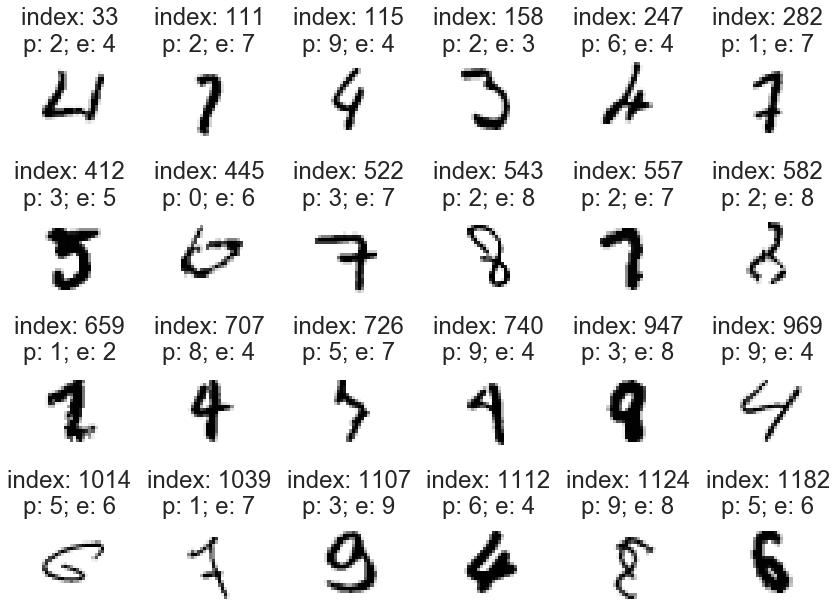

In [41]:
# Display 24 incorrect images labeled with each image's index
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(12, 9))

for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_axis_off()
    axes.set_title(f'index: {index}\np: {predicted}; e: {expected}')
plt.tight_layout()

### Final Review

The results of the model can also be reveiwed using a *confusion matrix* and by evaulating probabilities of incorrectly predicted digits. A *confusion matrix* will show the correct and incorrect predicted values (sometimes referred to *hits* and *missses*) for a given class. The `y_true` keyword argument specifies the test sample's actual classe. The `y_pred` specifies the predicted digits for those images. The lists `exp` and `pred` will be used as input. The incorrect predictions are shown on the diagonal from top-left to bottom-right. This is known as **principle diagonal**. The non-zero values that are not in the **principle diagonal** indicate incorrect predictions.

In [42]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_true = exp, y_pred = pred)
confusion

array([[ 968,    1,    4,    0,    0,    3,    1,    2,    1,    0],
       [   0, 1133,    0,    1,    0,    1,    0,    0,    0,    0],
       [   0,    1, 1025,    2,    0,    0,    0,    4,    0,    0],
       [   0,    1,    2, 1005,    0,    2,    0,    0,    0,    0],
       [   0,    1,   10,    0,  945,    0,    5,    2,    4,   15],
       [   0,    0,    2,    5,    0,  883,    1,    1,    0,    0],
       [   3,    2,    3,    0,    0,    4,  944,    0,    2,    0],
       [   1,    7,   27,    2,    0,    1,    0,  989,    0,    1],
       [   0,    1,    5,    8,    1,    0,    0,    1,  956,    2],
       [   2,    1,    2,    4,    0,    8,    1,    3,    3,  985]])

The `sklearn.metrics` module also provides the function `classification_report`. This funciton will produce a table of **classification metrics** based on expected and predicted values. 

* Precision - total number of correct predicitons for a given digit divided by the total number of predictions for that digit 

* Recall - total number of correct predictions for a given digit divided by the total number of samples that should have been predicted as that digit

* f1-score - The average of the *precision* and *recall*

* Support - The number of samples with a given expected value.

More information on those metrics is provided.

__[More info on classification metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures)__

__[More info on averages in report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)__

In [43]:
# view classification report
from sklearn.metrics import classification_report
names = np.asarray([str(x) for x in range(10)])
print(classification_report(exp, pred, target_names=names))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.98      1.00      0.99      1010
           4       1.00      0.96      0.98       982
           5       0.98      0.99      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.96      0.97      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



A `heatmap` from `seaborn` can help improve a confusion matrix by displaying values as colors, with values of higher magnitude displayed as more intense colors. *Seaborn's* graphing functions work with two-dimensional data. Using *Pandas* `pd.DataFrame` will allow *Seaborn* to automatically label its visualizations using the column names and row indices

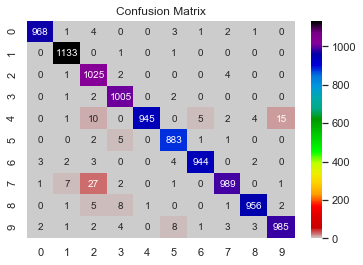

In [50]:
# Create heatmap
import pandas as pd
import seaborn as sns

confusion_df = pd.DataFrame(confusion,
                            index=range(10),
                            columns=range(10))


ax = sns.heatmap(confusion_df,annot=True,
                  cmap = 'nipy_spectral_r',fmt="d",annot_kws={"size": 10})
ax.set(title="Confusion Matrix")
sns.set(font_scale=1)
sns.set()

### Saving Model

Neural network models can require sigificant training time. A model can be saved and used later once it has been designed and tested. Sometimes a model needs to be reloaded for further training for new problems. For example, the layers in this model can now be used already know how to recognize features such as lines and curves. Therefore, it can be used as the basis of a more robust model. This is known as *transfer learning* - transfering a model's knowledge into a new model. **Keras** has included a method `save` that sil be used to store the model's architecture and state information in a **HDF5** (*hierarchical data format*) using the extenion *.h5*. A model can be reloaded using the `load_model` method. 

__[More info on Saving and Loading](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)__

In [49]:
# save model
cnn.save('mnist_cnn.h5')